In [1]:
import torch
from txai.models.encoders.transformer_simple import TransformerMVTS
from txai.utils.predictors.eval import eval_mv4
from txai.synth_data.simple_spike import SpikeTrainDataset
from txai.utils.data import process_Synth

In [2]:
D = process_Synth(split_no = 1, device = None, base_path = '/n/data1/hms/dbmi/zitnik/lab/users/owq978/TimeSeriesCBM/datasets/FreqShape')

model = TransformerMVTS(
    d_inp = 1,
    max_len = 50,
    n_classes = 4,
    trans_dim_feedforward = 16,
    trans_dropout = 0.1,
    d_pe = 16,
    # aggreg = 'mean',
    # norm_embedding = True
)

model.load_state_dict(torch.load('../models/transformer_split=1_cpu.pt'))

<All keys matched successfully>

In [3]:
X, times, y = D['test']

In [7]:
from txai.utils.predictors import eval_mvts_transformer

out = model.embed(X, times, captum_input = False)

In [8]:
print(out.shape)

torch.Size([1000, 17])


In [17]:
gt_exp = D['gt_exps'].float()
print(gt_exp.shape)

torch.Size([50, 1000, 1])


In [18]:
from txai.utils.functional import transform_to_attn_mask

attn_masks = transform_to_attn_mask(gt_exp.squeeze(-1).transpose(0,1))
print(attn_masks.shape)

torch.Size([1000, 50, 50])


In [19]:
out_masked = model.embed(X, times, captum_input = False, attn_mask = attn_masks)
print(out_masked.shape)

torch.Size([1000, 17])


In [20]:
import torch.nn.functional as F

sim = F.cosine_similarity(out, out_masked)
print(sim.mean().item())

0.301510751247406


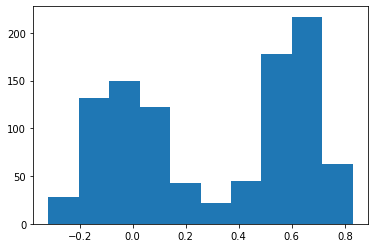

In [22]:
import matplotlib.pyplot as plt

plt.hist(sim.detach().numpy())
plt.show()

In [28]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

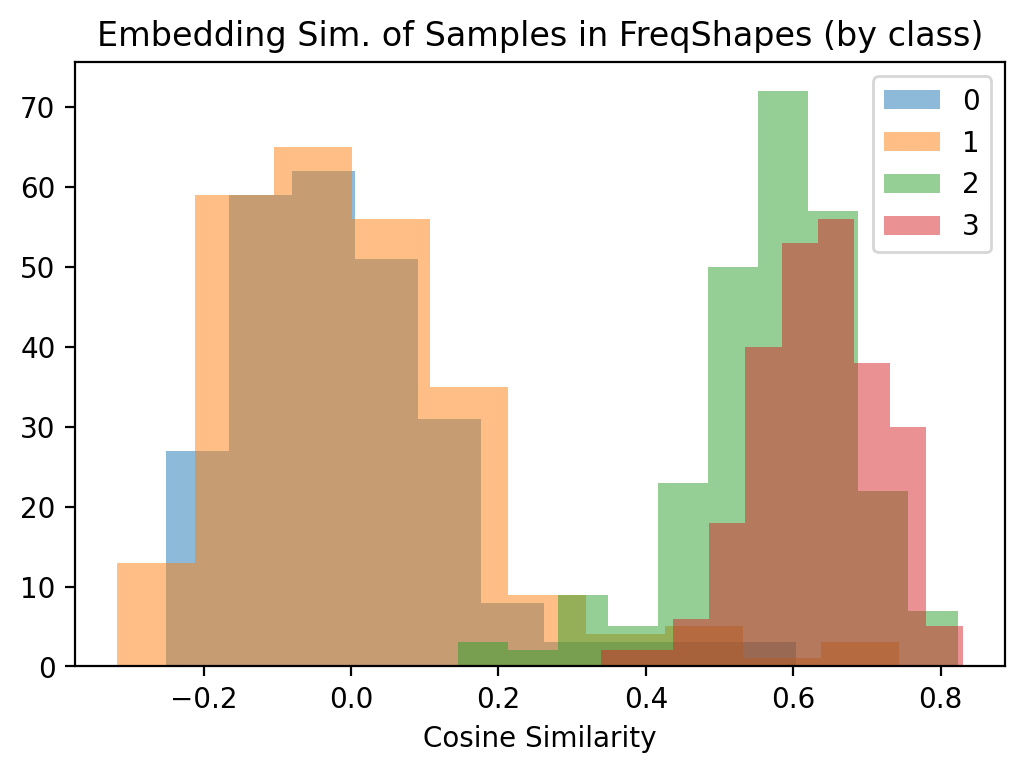

In [31]:
sim_np = sim.detach().numpy()
ynp = y.detach().numpy()
for yi in y.unique().detach().numpy():
    plt.hist(sim_np[ynp == yi], alpha = 0.5, label = '{}'.format(yi))
plt.legend()
plt.title('Embedding Sim. of Samples in FreqShapes (by class)')
plt.xlabel('Cosine Similarity')
plt.show()

In [32]:
# Get predictions of each:
pred = model(X, times)
pred_masked = model(X, times, attn_mask = attn_masks)

In [35]:
from sklearn.metrics import f1_score

pred_masked_np = pred_masked.argmax(dim=-1).detach().numpy()

f1 = f1_score(y, pred_masked_np, average = 'macro')
print(f1)

for yi in y.unique().detach().numpy():
    acc = (pred_masked_np[ynp == yi] == yi).sum() / (ynp == yi).sum()
    print('Acc. {} = {:.4f}'.format(yi, acc))

0.3226313841598816
Acc. 0 = 0.0000
Acc. 1 = 0.0000
Acc. 2 = 1.0000
Acc. 3 = 0.9360


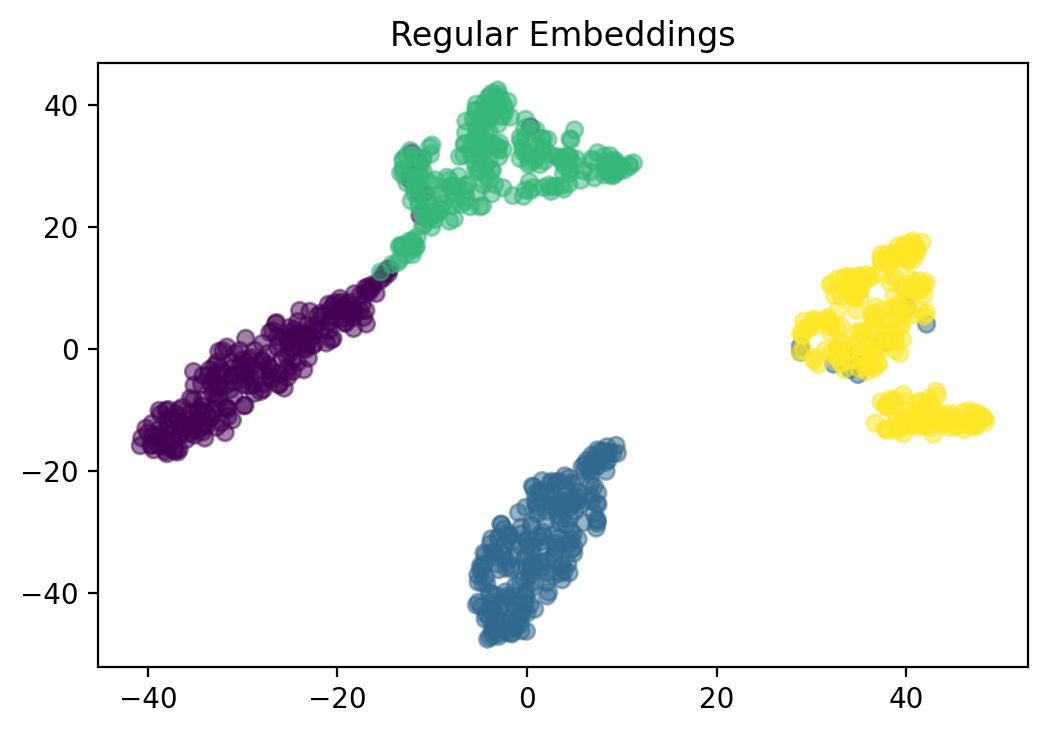

In [48]:
from sklearn.manifold import TSNE

out_tsne = TSNE().fit_transform(out.detach().numpy())
plt.scatter(out_tsne[:,0], out_tsne[:,1], c = ynp, alpha = 0.5)
plt.title('Regular Embeddings')
plt.show()

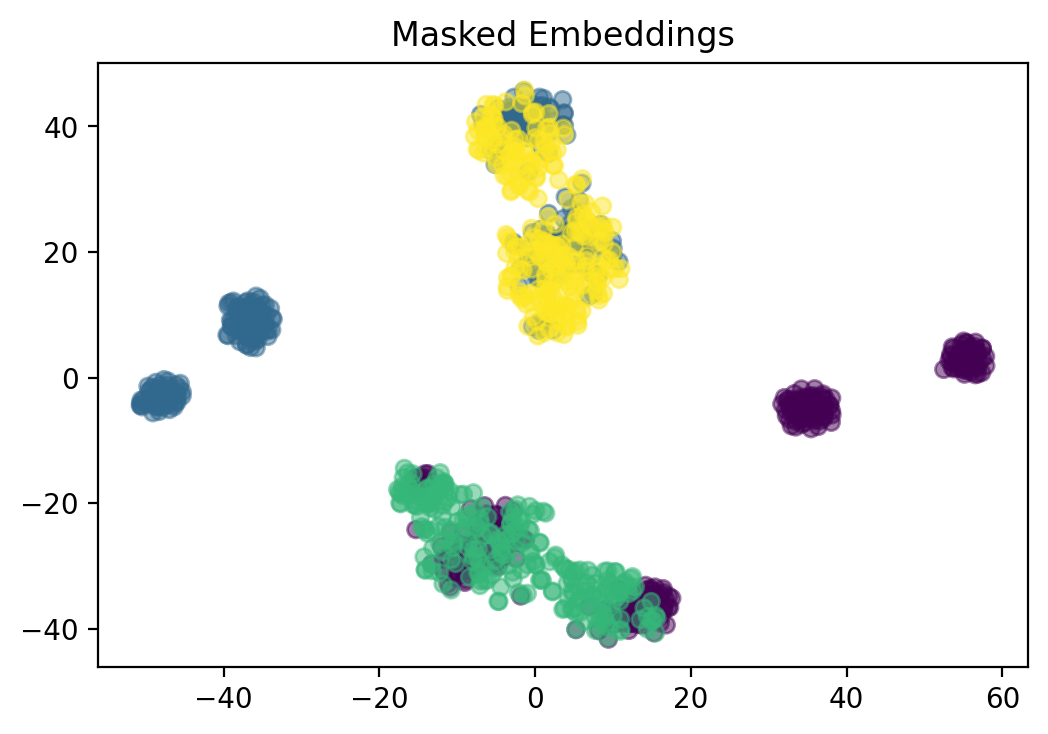

In [47]:
out_mask_tsne = TSNE().fit_transform(out_masked.detach().numpy())
plt.scatter(out_mask_tsne[:,0], out_mask_tsne[:,1], c = ynp, alpha = 0.5)
plt.title('Masked Embeddings')
plt.show()